**Install requirements**

In [ ]:
!pip install segmentation-models-pytorch
!pip install torchmetrics
!pip install fvcore
!pip install ptflops

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 2.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=63bed9c1a6d63f5b8d4c7f475340005d4cb67684a61fdde38e17ef818f5a2132
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=10d76a0adaf19a9eb789e2df4b47201693cebb008db1bcc1106babd582e83f75
  Stored in directory: /root/.cache/pip/wheels/5f/5b/96/fd94bc35962d7c6b699e8814db545155ac91d2b95785e1b035
Successfully built efficientnet-pytorch pretrainedmodels
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB

**Import libraries**

In [3]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import jaccard_score

import time

from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# **Global variables**

In [4]:
NUM_CLASSES = 7

BATCH_SIZE = 32     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                    # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.01             # The initial Learning Rate
MOMENTUM = 0.9        # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 0.0005 # Regularization, you can keep this at the default

NUM_EPOCHS = 20      # Total number of training epochs (iterations over dataset)
STEP_SIZE = [10, 15]    # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1             # Multiplicative factor for learning rate step-down

# **Dataset management**

**Download Dataset LoveDA**


In [18]:
#'''
#1yzLCHM-BHGaEvt5DqnCBzaLfLF-qOQ7M
if not os.path.isdir('/content/LoveDA'):
  # Download the LoveDA dataset if it doesn't exist in the directory
  !gdown --id 1yzLCHM-BHGaEvt5DqnCBzaLfLF-qOQ7M # Estimated time: 3-5 minutes
  !jar xvf  "/content/LoveDA.zip" # Extract the file

# Check if the dataset was copied correctly
if not os.path.isdir('/content/LoveDA'):
    print("Dataset doesn't exist")

#Weights
if not os.path.isfile("/content/PIDNet_S_ImageNet.pth.tar"):
  !gdown --id 1reDp2XdraXqPHXvmZvIXzXN8lrTphPk8

if not os.path.isfile("/content/best_model_pidnet_DS_512_32_wHF_FocalLoss_MultiStepLR.pth"):
  !gdown --id 1szRRktxhEIyiSg5yPrLj-z1YDX_vS-av

# Utilities
if not os.path.isfile("/content/model_utils.py"):
    # Download the model_utils.py script
    !gdown --id 1Uq3E3F6fO7qXInkS2IFGHS5WDxrrNSpr

'''

# OPTION 2
# Download LoveDA train an val dataset, from https://zenodo.org/records/5706578, extract and put them in a unique folder: LoveDA
# Download the Utils folder from github: https://github.com/Zafonte/Real-time-Domain-Adaptation-in-Semantic-Segmentation.git
# Upload in your drive the dataset and the Utils folder - then run the following line of code
from google.colab import drive
drive.mount('/content/drive')

# Copy the dataset from your Google Drive folder to /content
if not os.path.isdir('/content/LoveDA'):
    !cp -r "/content/drive/MyDrive/AMLProjectCode/LoveDA" /content/                        #PUT your path

# Check if the dataset has been copied correctly
if not os.path.isdir('/content/LoveDA'):
    print("Dataset doesn't exist")

#Weights
if not os.path.isfile("/content/PIDNet_S_ImageNet.pth.tar"):
  !cp -r "/content/drive/MyDrive/AMLProjectCode/Utils/PIDNet_S_ImageNet.pth.tar" /content/  #PUT your path

if not os.path.isfile("/content/best_model_pidnet_DS_512_32_wHF_FocalLoss_MultiStepLR.pth"):
  !cp -r "/content/drive/MyDrive/AMLProjectCode/Utils/best_model_pidnet_DS_512_32_wHF_FocalLoss_MultiStepLR.pth" /content/     #PUT your path

# Utilities
if not os.path.isfile("/content/model_utils.py"):
    !cp -r "/content/drive/MyDrive/AMLProjectCode/Utils/model_utils.py" /content/           #PUT your path
'''

Streaming output truncated to the last 5000 lines.
 inflated: LoveDA/Train/Urban/images_png/2024.png
 inflated: LoveDA/Train/Urban/images_png/2025.png
 inflated: LoveDA/Train/Urban/images_png/2026.png
 inflated: LoveDA/Train/Urban/images_png/2027.png
 inflated: LoveDA/Train/Urban/images_png/2028.png
 inflated: LoveDA/Train/Urban/images_png/2029.png
 inflated: LoveDA/Train/Urban/images_png/2030.png
 inflated: LoveDA/Train/Urban/images_png/2031.png
 inflated: LoveDA/Train/Urban/images_png/2032.png
 inflated: LoveDA/Train/Urban/images_png/2033.png
 inflated: LoveDA/Train/Urban/images_png/2034.png
 inflated: LoveDA/Train/Urban/images_png/2035.png
 inflated: LoveDA/Train/Urban/images_png/2036.png
 inflated: LoveDA/Train/Urban/images_png/2037.png
 inflated: LoveDA/Train/Urban/images_png/2038.png
 inflated: LoveDA/Train/Urban/images_png/2039.png
 inflated: LoveDA/Train/Urban/images_png/2040.png
 inflated: LoveDA/Train/Urban/images_png/2041.png
 inflated: LoveDA/Train/Urban/images_png/2042.png

'\n\n# OPTION 2\n# Download LoveDA train an val dataset, from https://zenodo.org/records/5706578, extract and put them in a unique folder: LoveDA\n# Download the Utils folder from github: https://github.com/Zafonte/Real-time-Domain-Adaptation-in-Semantic-Segmentation.git\n# Upload in your drive the dataset and the Utils folder - then run the following line of code\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n\n# Copy the dataset from your Google Drive folder to /content\nif not os.path.isdir(\'/content/LoveDA\'):\n    !cp -r "/content/drive/MyDrive/AMLProjectCode/LoveDA" /content/                        #PUT your path\n\n# Check if the dataset has been copied correctly\nif not os.path.isdir(\'/content/LoveDA\'):\n    print("Dataset doesn\'t exist")\n\n#Weights\nif not os.path.isfile("/content/PIDNet_S_ImageNet.pth.tar"):\n  !cp -r "/content/drive/MyDrive/AMLProjectCode/Utils/PIDNet_S_ImageNet.pth.tar" /content/  #PUT your path\n\nif not os.path.isfile("/content/bes

**LoveDA dataset class**


In [5]:
COLOR_MAP = OrderedDict(
    Black = (0, 0, 0),
    Background=(255, 255, 255),
    Building=(255, 0, 0),
    Road=(255, 255, 0),
    Water=(0, 0, 255),
    Barren=(159, 129, 183),
    Forest=(0, 255, 0),
    Agricultural=(255, 195, 128),
)


LABEL_MAP = OrderedDict(
    Black = -1,
    Background=0,
    Building=1,
    Road=2,
    Water=3,
    Barren=4,
    Forest=5,
    Agricultural=6
)


def map_labels(label):
    mapped_label = np.where(label == 0, -1, np.where(label >= 1, label - 1, label)) # Change pixel values
    return torch.tensor(mapped_label, dtype=torch.long)


class LoveDADataset(Dataset):
    def __init__(self, images_path, masks_path, image_transform=None, mask_transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = sorted([f for f in os.listdir(images_path) if f.endswith('.png')])
        self.masks = sorted([f for f in os.listdir(masks_path) if f.endswith('.png')])

        # Check if the number of images matches the number of masks
        if len(self.images) != len(self.masks):
            raise ValueError("The number of images and masks does not match!")

    def __getitem__(self, idx):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target)
        '''
        # Read image and mask
        image = Image.open(os.path.join(self.images_path, self.images[idx])).convert('RGB')
        mask = Image.open(os.path.join(self.masks_path, self.masks[idx]))

        # Apply transformation to images (if present)
        if self.image_transform:
            image = self.image_transform(image)

        # Apply transformation to masks (if present)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        # Convert mask to NumPy array for mapping
        mask_np = np.array(mask, dtype=np.int64)

        # Map labels using map_labels function
        mask_mapped = map_labels(mask_np)

        return image, mask_mapped

    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        return len(self.images)

# **Network setup**

**PIDNet**: a real-time segmentation network

In [7]:
# ------------------------------------------------------------------------------
# Written by Jiacong Xu (jiacong.xu@tamu.edu)
# ------------------------------------------------------------------------------
import sys
import os

from model_utils import BasicBlock, Bottleneck, segmenthead, DAPPM, PAPPM, PagFM, Bag, Light_Bag

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import logging

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch - extracts key features at reduced resolutions
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch - optimized for scene parsing
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch - captures fine details (edges, contours)
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_

def get_seg_model(cfg, imgnet_pretrained):

    if 's' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=112, head_planes=256, augment=True)

    if imgnet_pretrained:
        print('PIDNet-S backbone pretraining on ImageNet loading...')
        pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model.load_state_dict(model_dict, strict = False)
        print('PIDNet-S backbone pretraining on ImageNet LOADED')
    else:
        pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

def get_pred_model(name, num_classes):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=False)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=False)

    return model

In [8]:
# Configuration with the path to the pre-trained file
class Config:
    class MODEL:
        NAME = 's'  # Specify the model ('s', 'm', etc.)
        PRETRAINED = '/content/PIDNet_S_ImageNet.pth.tar'  # Path to file PIDNet_S pretrainato on ImageNet

    class DATASET:
        NUM_CLASSES = NUM_CLASSES  # Number of classes in the dataset


**Visualize prediction function**

In [9]:
def visualize_prediction(image, true_mask, pred_mask):
    """
    Visualizes the original image, true mask, and predicted mask.
    Parameters:
    - image: Tensor image (C, H, W).
    - true_mask: Tensor ground truth mask.
    - pred_mask: Tensor predicted mask.
    """

    print("Comparison of true mask and prediction for a sample train image:")

    # Define ImageNet mean and standard deviation
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    image = image.cpu().numpy().transpose(1, 2, 0)  # Change image shape for matplotlib

    # If the image was normalized for the model, we need to de-normalize it
    # De-normalize the image
    image = image * std + mean  # Inverse of normalization
    image = np.clip(image, 0, 1)  # Ensure values are in the range [0, 1]

    # Convert image and masks to numpy arrays for visualization
    true_mask_np = np.array(true_mask.cpu(), dtype=np.int64)
    pred_mask_np = np.array(pred_mask.cpu(), dtype=np.int64)

    # Create a colored mask based on LABEL_MAP and COLOR_MAP
    colored_true_mask = np.zeros((true_mask_np.shape[0], true_mask_np.shape[1], 3), dtype=np.uint8)
    colored_pred_mask = np.zeros((pred_mask_np.shape[0], pred_mask_np.shape[1], 3), dtype=np.uint8)
    for class_name, color in COLOR_MAP.items():
        class_value = LABEL_MAP[class_name]  # Get the numerical value for the class
        colored_true_mask[true_mask_np == class_value] = color  # Apply correct color
        colored_pred_mask[pred_mask_np == class_value] = color  # Apply correct color

    # Create figure with subplots
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # True mask
    ax[1].imshow(colored_true_mask)
    ax[1].set_title('True Mask')
    ax[1].axis('off')
    print(f"Unique values (mapped) in true mask: {np.unique(true_mask_np)}")

    # Predicted mask
    ax[2].imshow(colored_pred_mask)
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')
    print(f"Unique values in predicted mask: {np.unique(pred_mask_np)}")
    print()

    legend_patches = [mpatches.Patch(color=np.array(color) / 255.0, label=class_name) for class_name, color in COLOR_MAP.items()]
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
    # Save or show the image
    plt.show()

# **Define Data Preprocessing**

In [10]:
# Image transformation
image_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(), # Turn PIL Image to torch.Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #Normalization - Pre-trained models on ImageNet (such as ResNet101 for DeepLabV2 and PIDNet-S) expect normalized images.
])

# Mask transformation
mask_transform = transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.NEAREST)


In [11]:
# Data augmentation
import random
import torchvision.transforms.functional as TF
import torchvision.transforms as T

# Definizione delle trasformazioni di data augmentation
class DataAugmentation:
    def __init__(self, probability=0.5):
        self.probability = probability
        self.transforms = [
            self.horizontal_flip
            #self.gaussian_blur,
            #self.multiply,
            #self.vertical_flip
        ]

    def __call__(self, image, mask):
        if random.random() < self.probability:
            for transform in self.transforms:
                image, mask = transform(image, mask)
        return image, mask

    def horizontal_flip(self, image, mask):
        """Flip orizzontale."""
        return TF.hflip(image), TF.hflip(mask)

    def gaussian_blur(self, image, mask):
        """Blur gaussiano con raggio casuale tra 1 e 3."""
        """GaussianBlur è un filtro che sfuma un'immagine applicando un kernel gaussiano. Serve per ridurre i dettagli o il rumore in un'immagine.
        Nella data augmentation, viene usato per simulare scenari in cui l'immagine potrebbe apparire meno definita,
        come accade in presenza di nebbia, sfocature della lente o visibilità limitata."""
        blur = T.GaussianBlur(kernel_size=(5, 5), sigma=(1, 3))
        return blur(image), mask

    def multiply(self, image, mask):
        """Modifica casuale della luminosità di un fattore compreso tra 0.7-1.3."""
        factor = random.uniform(0.7, 1.3)  # Fattor di moltiplicazione casuale
        return image * factor, mask

    def vertical_flip(self, image, mask):
        """Flip verticale."""
        return TF.vflip(image), TF.vflip(mask)

# **Dataset object**

In [19]:
train_dataset = LoveDADataset(
    "/content/LoveDA/Train/Urban/images_png",
    "/content/LoveDA/Train/Urban/masks_png",
    image_transform=image_transform,
    mask_transform=mask_transform
)

print(f"Number of images in the Urban train dataset: {len(train_dataset)}")

val_dataset = LoveDADataset(
    "/content/LoveDA/Val/Rural/images_png",
    "/content/LoveDA/Val/Rural/masks_png",
    image_transform=image_transform,
    mask_transform=mask_transform
)

print(f"Number of images in the Rural validation dataset: {len(val_dataset)}")

Number of images in the Urban train dataset: 1156
Number of images in the Rural validation dataset: 992


# **Dataloaders**

In [20]:
#DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) #batch_size: numero di immagini processate contemporaneamente
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# **Prepare Network**

In [21]:
# Crea l'oggetto di configurazione
cfg = Config()

# Get the model with pretrained weights from ImageNet
model = get_seg_model(cfg, imgnet_pretrained = True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

PIDNet-S backbone pretraining on ImageNet loading...
PIDNet-S backbone pretraining on ImageNet LOADED


<ipython-input-7-8498e26dc231>:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']


# Class **weights**

In [ ]:
import numpy as np
import torch

def calculate_class_weights(device=device):
    """
    Calcola i pesi delle classi inversamente proporzionali alla loro frequenza nel dataset.

    Argomenti:
    set di dati (Dataset): Il dataset di riferimento.
    num_classes (int): Numero totale di classi.
    dispositivo (str): Dispositivo su cui calcolare i pesi.

    Resi:
    torcia.Tensore: Tensore contenente i pesi per ciascuna classe.
    """
    num_classes = NUM_CLASSES
    class_counts = torch.zeros(num_classes).to(device)
    total_pixels = 0

    for _, mask in tqdm(train_loader, desc="Computation of the weights of each class"):
        mask = mask.to(device).squeeze(0)
        for cls in range(num_classes):
            class_counts[cls] += torch.sum(mask == cls)
        total_pixels += mask.numel()

    # To avoid division by zero
    class_freq = class_counts / total_pixels
    class_weights = 1.0 / (class_freq + 1e-6)

    # Normalization of the weights
    class_weights = class_weights / class_weights.sum() * num_classes

    return class_weights, class_freq

weights, class_freq = calculate_class_weights()
print(weights, class_freq)

Computation of the weights of each class: 100%|██████████| 37/37 [01:15<00:00,  2.04s/it]


tensor([0.1164, 0.2660, 0.6078, 1.5114, 0.7455, 0.7125, 3.0403],
       device='cuda:0') tensor([0.4612, 0.2018, 0.0883, 0.0355, 0.0720, 0.0754, 0.0177],
       device='cuda:0')


In [ ]:
#weights result: [0.1166, 0.2659, 0.6086, 1.5109, 0.7446, 0.7193, 3.0340],
#class_freq result: [0.4610, 0.2022, 0.0883, 0.0356, 0.0722, 0.0747, 0.0177]

class_weights = torch.tensor([0.4, 0.6, 0.9, 0.9, 1.7, 1.5, 1.0]).to('cuda')

# **Validation setup**

In [16]:
# Label mapping, excluding Black class (index -1)
LABEL = {
    'Background': 0,
    'Building': 1,
    'Road': 2,
    'Water': 3,
    'Barren': 4,
    'Forest': 5,
    'Agricultural': 6
}

# Function to compute confusion matrix
# a: ground truth, b: predictions, n: number of classes
def fast_hist(a, b, n):
    """
    Compute a confusion matrix between classes.

    Args:
        a (np.array): Ground truth (1D or 2D array).
        b (np.array): Prediction (1D or 2D array).
        n (int): Number of classes.

    Returns:
        np.array: Confusion matrix of shape n x n.
    """
    # Create a boolean index for valid values
    k = (a >= 0) & (a < n)

    # Compute confusion matrix
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)

# Function to compute IoU per class
def per_class_iou(hist):
    epsilon = 1e-5  # Small constant to avoid division by zero
    # intersection = values on the diagonal of the confusion matrix
    return np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)

# Function to compute mIoU on validation set
def compute_mIoU(model, val_loader, num_classes, device):
    model.eval()
    hist = np.zeros((num_classes, num_classes))

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            outputs_resized = torch.nn.functional.interpolate(
                outputs,
                size=(512, 512),
                mode='bilinear'
            )

            preds = torch.argmax(outputs_resized, dim=1) # Predicted class

            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            for lt, lp in zip(masks, preds):
                hist += fast_hist(lt.flatten(), lp.flatten(), num_classes)

    iou = per_class_iou(hist)
    mIoU = np.mean(iou)

    # Print IoU per class with class names
    print("IoU per category (%):")
    for class_idx in range(num_classes):
        class_name = list(LABEL.keys())[list(LABEL.values()).index(class_idx)]
        print(f" {class_name}: {iou[class_idx] * 100:.2f}%")
    print()

    print(f"mIoU: {mIoU * 100:.2f}%")
    print()
    return mIoU

# ***Focal Loss***

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, ignore_index=-1):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index

    def forward(self, inputs, targets, mask=None):
        # Applicare la maschera direttamente ai logit o alle probabilità
        if mask is not None:
            inputs = inputs * mask.unsqueeze(1)  # Espandi il canale per matchare le dimensioni di `inputs`

        # Calcolo della Cross Entropy Loss ignorando pixel non validi
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', ignore_index=self.ignore_index)

        # Calcolo delle probabilità corrette
        pt = torch.exp(-ce_loss)

        # Calcolo della Focal Loss
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.sum() / mask.sum() if mask is not None else focal_loss.mean()

# **Training**


In [ ]:
trained = True #SET to true if you want use the pretrained weights otherwise False
plot_training = False

Epoch 1/20:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-23-3604e3856d7b>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/20: 100%|██████████| 37/37 [01:27<00:00,  2.36s/it]


Epoch 1, Learning Rate: 0.010000, Average Loss: 1.6283


IoU per category (%):
 Background: 24.83%
 Building: 21.96%
 Road: 13.69%
 Water: 19.80%
 Barren: 4.05%
 Forest: 4.25%
 Agricultural: 4.05%

mIoU: 13.23%

New best model saved with mIoU: 0.1323
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5]
Unique values in predicted mask: [0 1 2 5]



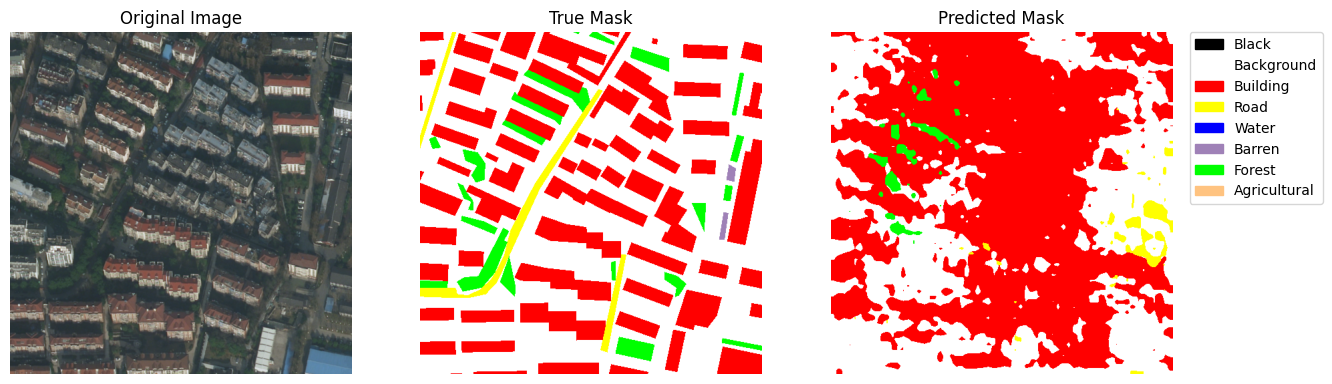

Epoch 2/20: 100%|██████████| 37/37 [01:22<00:00,  2.24s/it]


Epoch 2, Learning Rate: 0.010000, Average Loss: 0.5479


IoU per category (%):
 Background: 39.61%
 Building: 29.87%
 Road: 22.45%
 Water: 16.96%
 Barren: 3.17%
 Forest: 8.53%
 Agricultural: 15.04%

mIoU: 19.38%

New best model saved with mIoU: 0.1938
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 5]
Unique values in predicted mask: [0 1 2 4 5]



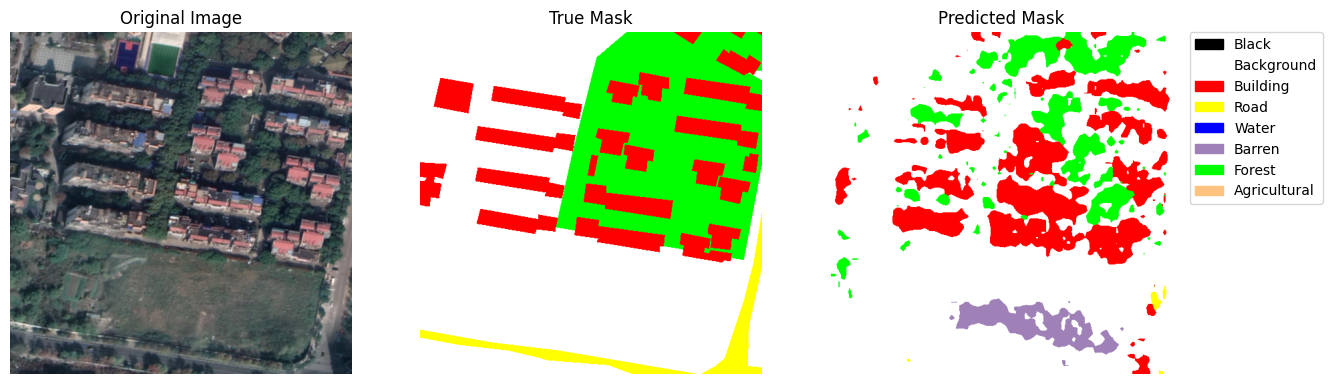

Epoch 3/20: 100%|██████████| 37/37 [01:24<00:00,  2.28s/it]



Epoch 3, Learning Rate: 0.010000, Average Loss: 0.4455
IoU per category (%):
 Background: 34.02%
 Building: 31.64%
 Road: 25.04%
 Water: 14.93%
 Barren: 4.85%
 Forest: 9.35%
 Agricultural: 21.73%

mIoU: 20.22%

New best model saved with mIoU: 0.2022
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 3 5]
Unique values in predicted mask: [0 1 2 3 5]



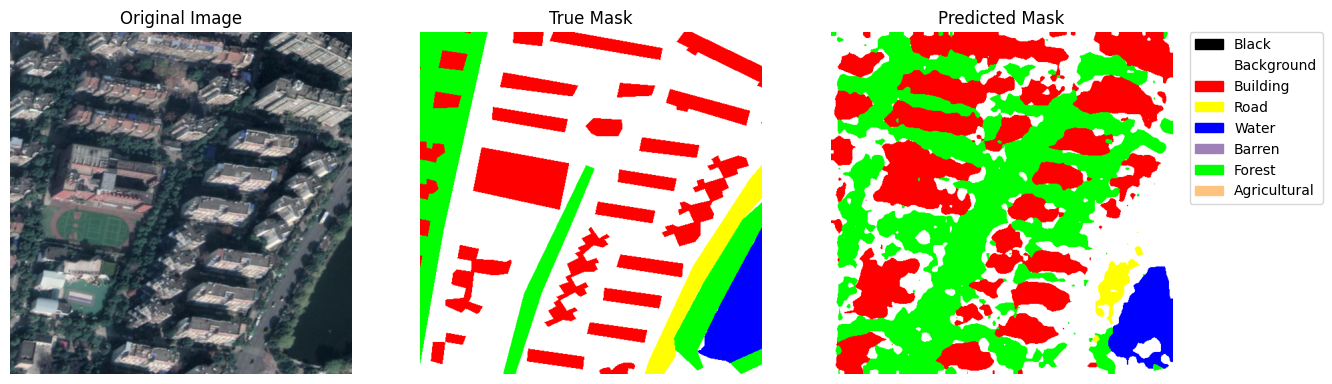

Epoch 4/20: 100%|██████████| 37/37 [01:23<00:00,  2.26s/it]


Epoch 4, Learning Rate: 0.010000, Average Loss: 0.4400


IoU per category (%):
 Background: 38.59%
 Building: 33.86%
 Road: 24.07%
 Water: 15.13%
 Barren: 3.06%
 Forest: 9.81%
 Agricultural: 22.33%

mIoU: 20.98%

New best model saved with mIoU: 0.2098
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [-1  0  1  2  4  5]
Unique values in predicted mask: [0 1 2 3 4 5]



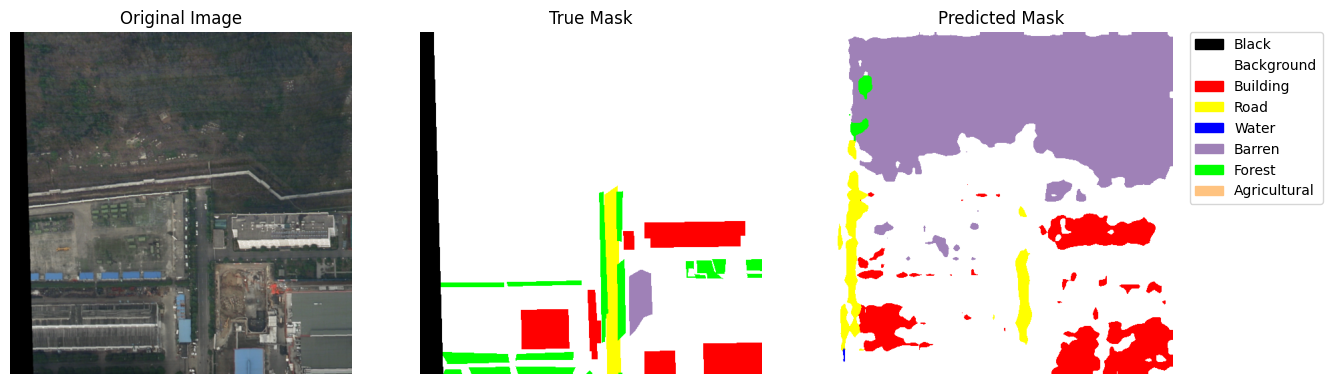

Epoch 5/20: 100%|██████████| 37/37 [01:22<00:00,  2.22s/it]


Epoch 5, Learning Rate: 0.010000, Average Loss: 0.4175


IoU per category (%):
 Background: 43.64%
 Building: 36.54%
 Road: 27.13%
 Water: 15.00%
 Barren: 5.44%
 Forest: 7.88%
 Agricultural: 29.61%

mIoU: 23.60%

New best model saved with mIoU: 0.2360
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2]
Unique values in predicted mask: [0 1 2 5]



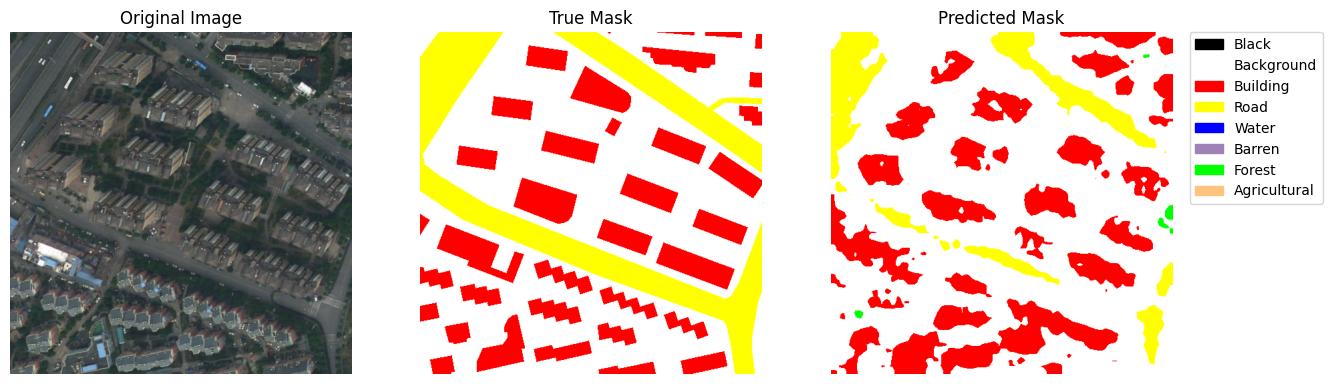

Epoch 6/20: 100%|██████████| 37/37 [01:22<00:00,  2.22s/it]


Epoch 6, Learning Rate: 0.010000, Average Loss: 0.3599


IoU per category (%):
 Background: 41.26%
 Building: 36.05%
 Road: 28.52%
 Water: 24.48%
 Barren: 6.29%
 Forest: 9.39%
 Agricultural: 31.54%

mIoU: 25.36%

New best model saved with mIoU: 0.2536
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5]
Unique values in predicted mask: [0 1 2 4 5]



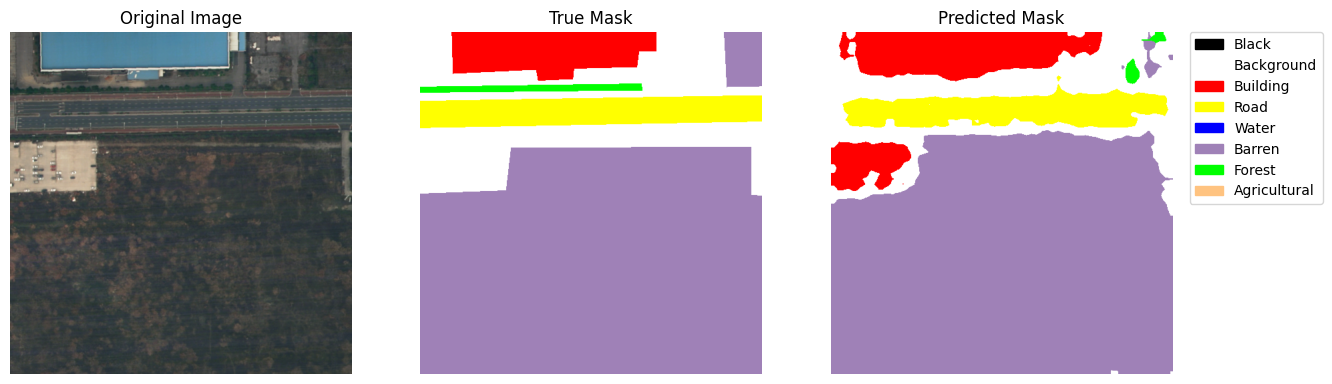

Epoch 7/20: 100%|██████████| 37/37 [01:24<00:00,  2.28s/it]


Epoch 7, Learning Rate: 0.010000, Average Loss: 0.3487


IoU per category (%):
 Background: 46.15%
 Building: 34.43%
 Road: 24.52%
 Water: 26.06%
 Barren: 6.62%
 Forest: 5.20%
 Agricultural: 22.13%

mIoU: 23.59%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [-1  0  1  2  4]
Unique values in predicted mask: [0 1 2 3 4 5]



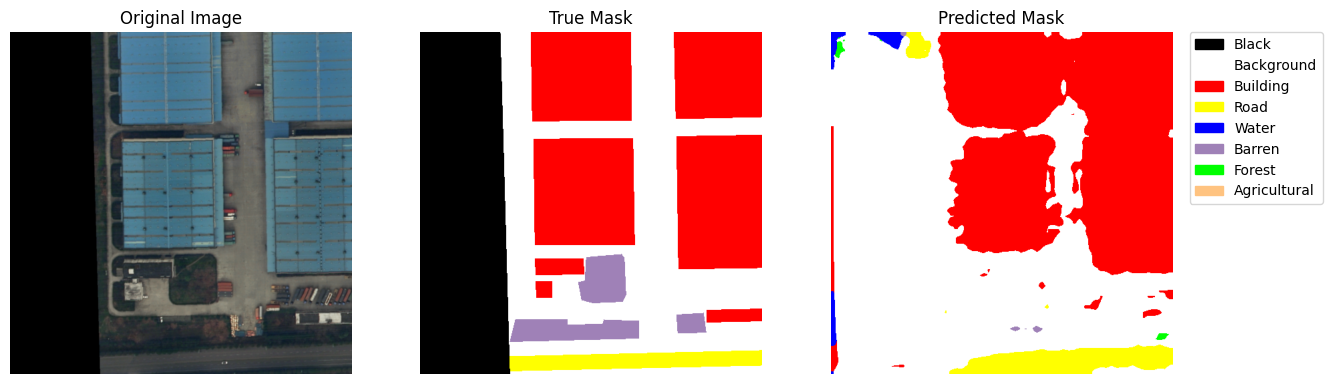

Epoch 8/20: 100%|██████████| 37/37 [01:22<00:00,  2.23s/it]


Epoch 8, Learning Rate: 0.010000, Average Loss: 0.3222


IoU per category (%):
 Background: 43.02%
 Building: 37.00%
 Road: 29.57%
 Water: 24.55%
 Barren: 5.85%
 Forest: 9.32%
 Agricultural: 30.98%

mIoU: 25.76%

New best model saved with mIoU: 0.2576
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5]
Unique values in predicted mask: [0 1 2 4 5]



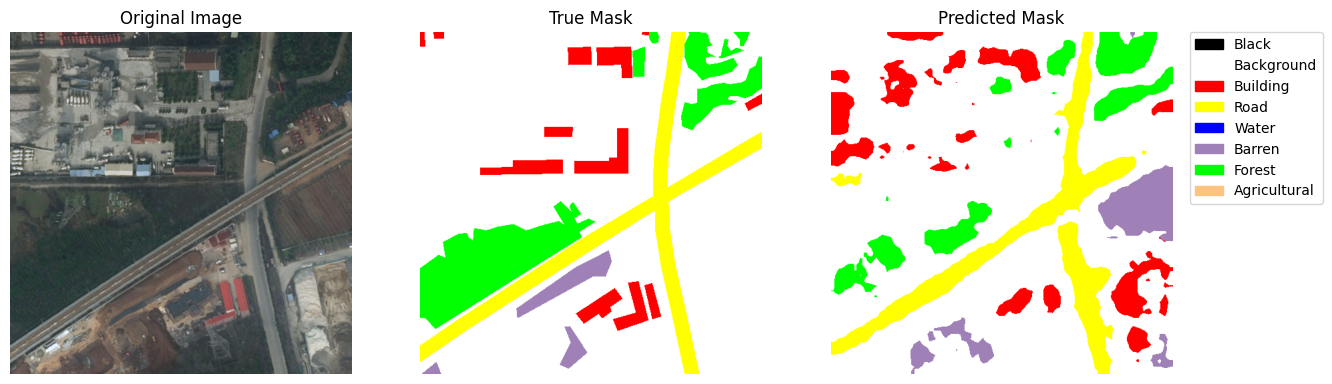

Epoch 9/20: 100%|██████████| 37/37 [01:22<00:00,  2.23s/it]


Epoch 9, Learning Rate: 0.010000, Average Loss: 0.2984


IoU per category (%):
 Background: 45.81%
 Building: 33.85%
 Road: 27.62%
 Water: 26.98%
 Barren: 6.31%
 Forest: 8.95%
 Agricultural: 30.64%

mIoU: 25.74%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 3 4 5]
Unique values in predicted mask: [0 1 2 3 4 5]



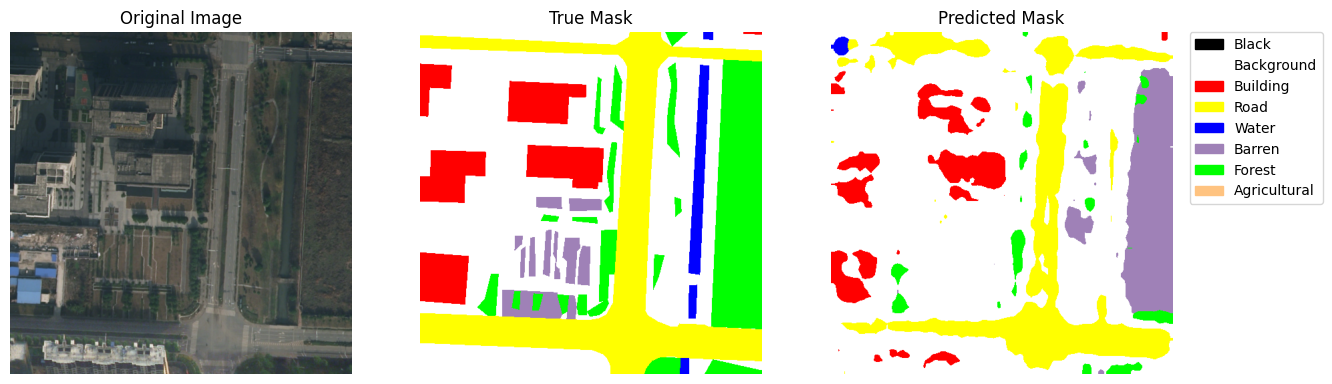

Epoch 10/20: 100%|██████████| 37/37 [01:22<00:00,  2.23s/it]


Epoch 10, Learning Rate: 0.001000, Average Loss: 0.2977


IoU per category (%):
 Background: 46.41%
 Building: 36.12%
 Road: 29.52%
 Water: 23.77%
 Barren: 5.95%
 Forest: 6.50%
 Agricultural: 34.43%

mIoU: 26.10%

New best model saved with mIoU: 0.2610
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 5]
Unique values in predicted mask: [0 1 2 4 5]



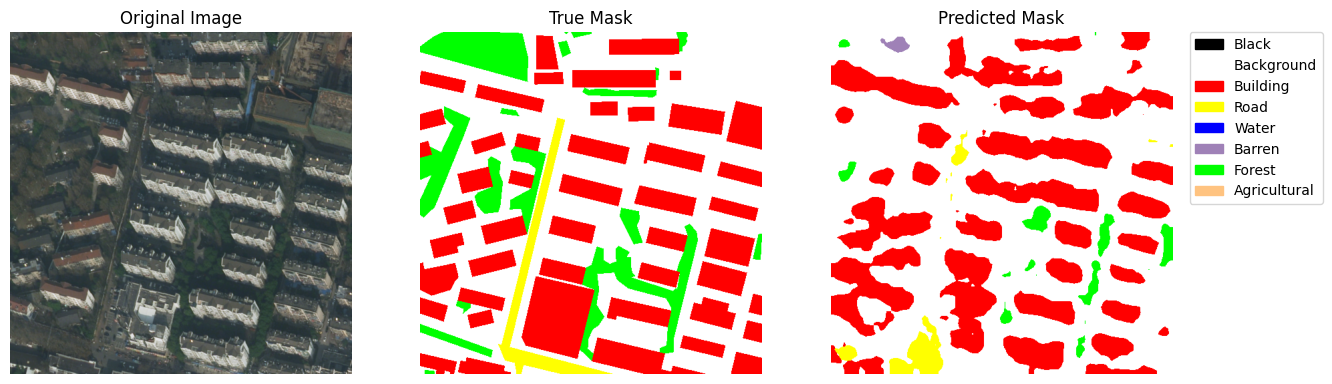

Epoch 11/20: 100%|██████████| 37/37 [01:22<00:00,  2.23s/it]


Epoch 11, Learning Rate: 0.001000, Average Loss: 0.2691


IoU per category (%):
 Background: 42.76%
 Building: 33.96%
 Road: 30.45%
 Water: 26.82%
 Barren: 4.23%
 Forest: 8.92%
 Agricultural: 34.35%

mIoU: 25.93%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 3 4 5]
Unique values in predicted mask: [0 1 2 3 5]



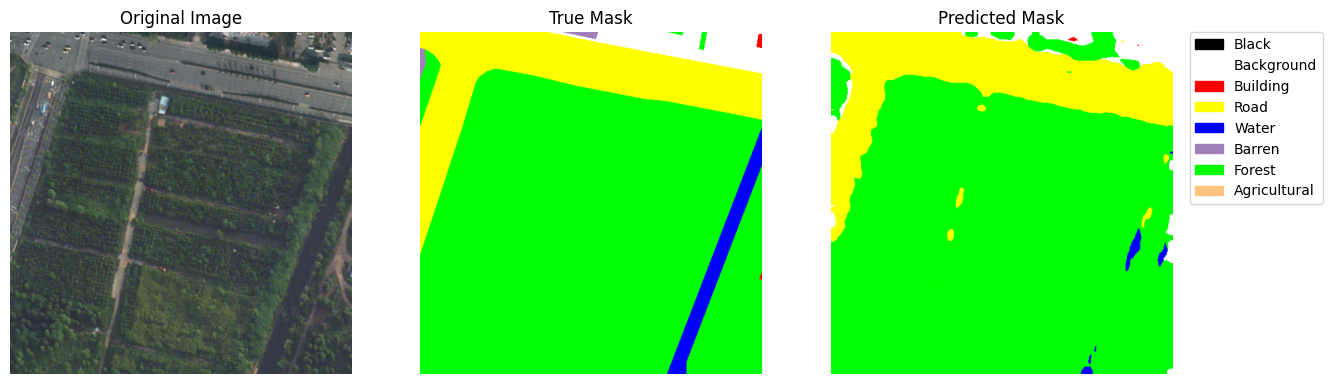

Epoch 12/20: 100%|██████████| 37/37 [01:21<00:00,  2.22s/it]


Epoch 12, Learning Rate: 0.001000, Average Loss: 0.2738


IoU per category (%):
 Background: 44.61%
 Building: 33.84%
 Road: 29.29%
 Water: 27.85%
 Barren: 5.09%
 Forest: 8.01%
 Agricultural: 31.97%

mIoU: 25.81%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 3 4 5]
Unique values in predicted mask: [0 1 2 3 4 5]



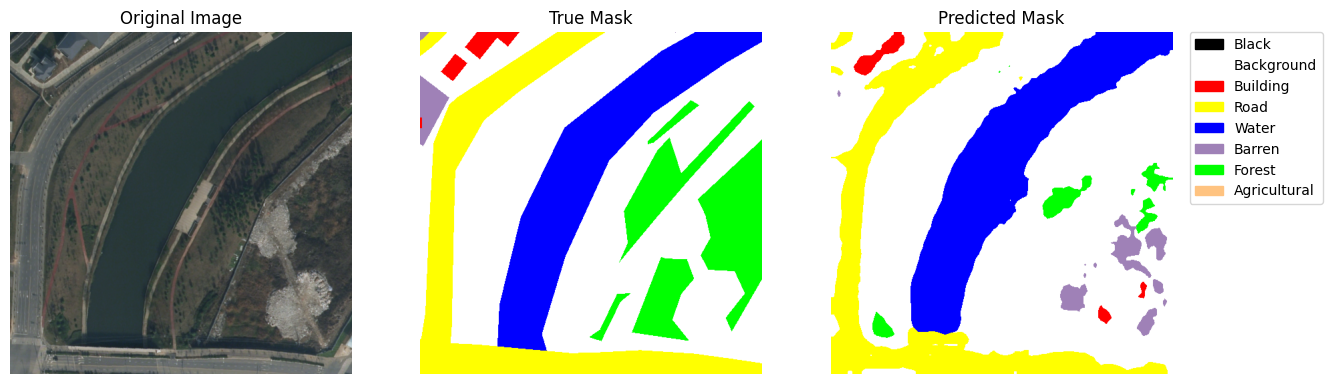

Epoch 13/20: 100%|██████████| 37/37 [01:23<00:00,  2.25s/it]


Epoch 13, Learning Rate: 0.001000, Average Loss: 0.2693


IoU per category (%):
 Background: 45.53%
 Building: 36.70%
 Road: 30.47%
 Water: 28.10%
 Barren: 5.27%
 Forest: 8.80%
 Agricultural: 34.16%

mIoU: 27.00%

New best model saved with mIoU: 0.2700
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [-1  0  1  2  3]
Unique values in predicted mask: [0 1 2 3 4 5 6]



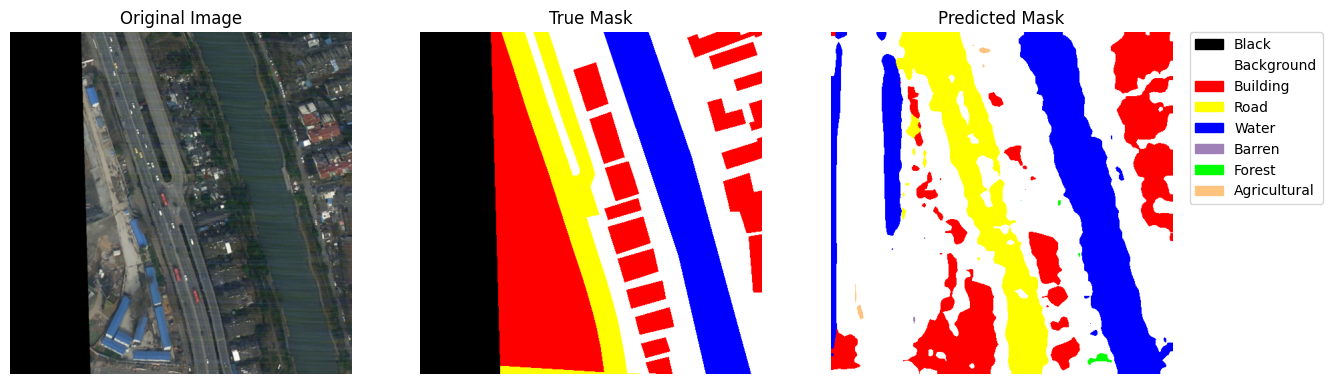

Epoch 14/20: 100%|██████████| 37/37 [01:21<00:00,  2.21s/it]


Epoch 14, Learning Rate: 0.001000, Average Loss: 0.2790


IoU per category (%):
 Background: 45.12%
 Building: 36.01%
 Road: 29.48%
 Water: 26.64%
 Barren: 4.89%
 Forest: 8.50%
 Agricultural: 34.01%

mIoU: 26.38%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 3 4 5 6]
Unique values in predicted mask: [0 1 2 3 4 5 6]



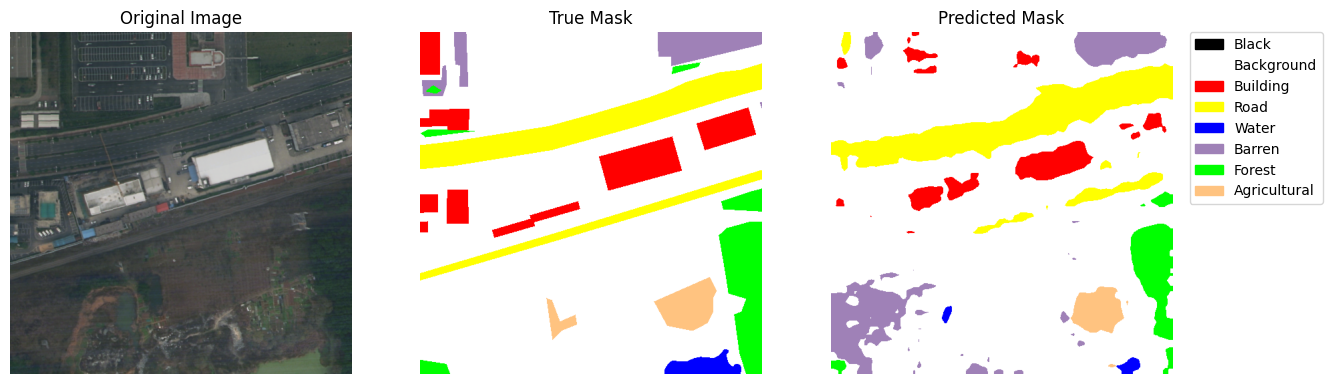

Epoch 15/20: 100%|██████████| 37/37 [01:19<00:00,  2.14s/it]


Epoch 15, Learning Rate: 0.000100, Average Loss: 0.2744


IoU per category (%):
 Background: 44.16%
 Building: 34.15%
 Road: 29.34%
 Water: 27.09%
 Barren: 5.64%
 Forest: 8.70%
 Agricultural: 30.87%

mIoU: 25.71%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2]
Unique values in predicted mask: [0 1 2 5]



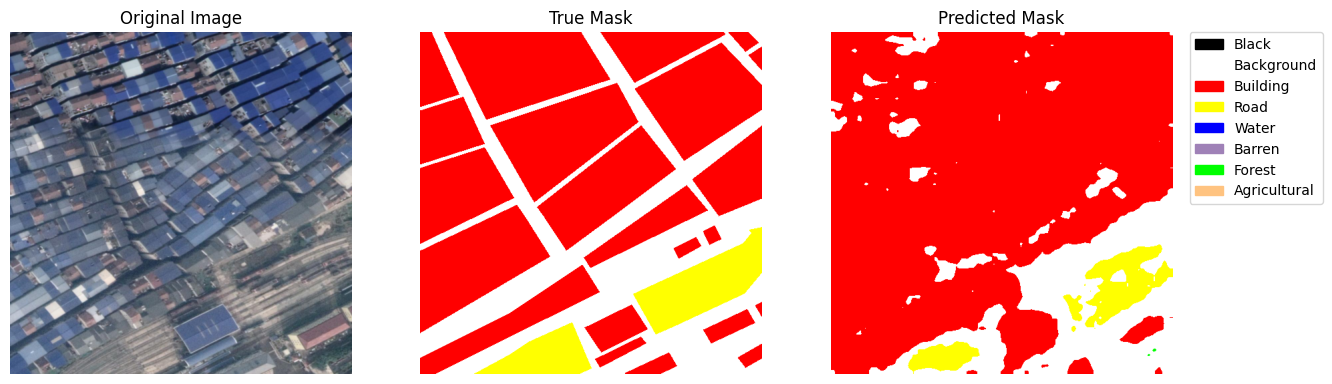

Epoch 16/20: 100%|██████████| 37/37 [01:20<00:00,  2.18s/it]



Epoch 16, Learning Rate: 0.000100, Average Loss: 0.2780
IoU per category (%):
 Background: 44.39%
 Building: 34.32%
 Road: 29.35%
 Water: 25.62%
 Barren: 5.42%
 Forest: 8.49%
 Agricultural: 32.62%

mIoU: 25.74%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 5]
Unique values in predicted mask: [0 1 2 4 5]



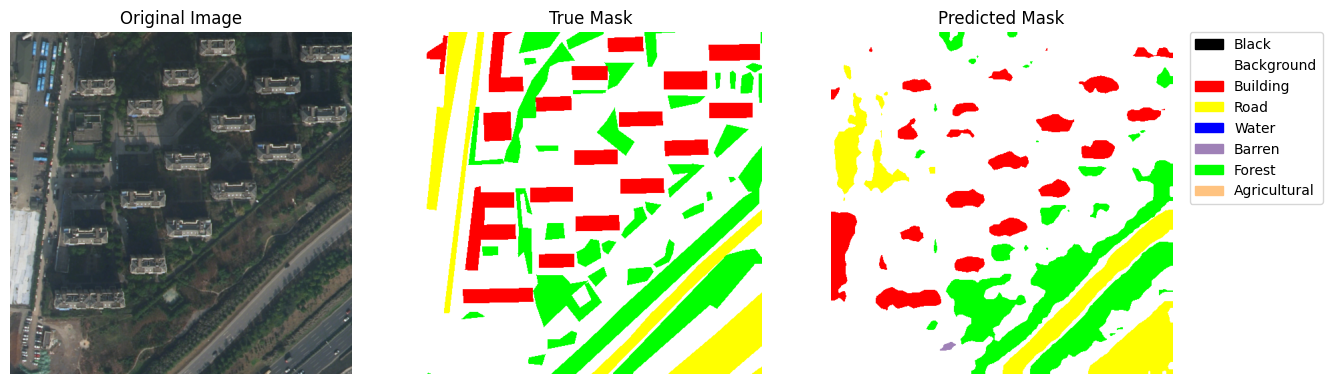

Epoch 17/20: 100%|██████████| 37/37 [01:23<00:00,  2.27s/it]


Epoch 17, Learning Rate: 0.000100, Average Loss: 0.2663


IoU per category (%):
 Background: 43.39%
 Building: 34.93%
 Road: 30.00%
 Water: 28.00%
 Barren: 4.70%
 Forest: 9.45%
 Agricultural: 31.00%

mIoU: 25.92%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2]
Unique values in predicted mask: [0 1 2 5]



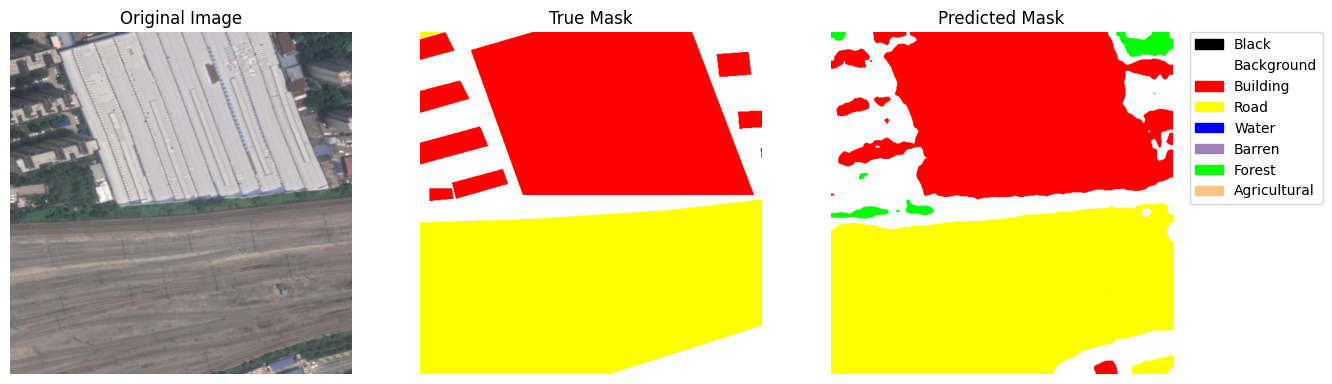

Epoch 18/20: 100%|██████████| 37/37 [01:22<00:00,  2.23s/it]


Epoch 18, Learning Rate: 0.000100, Average Loss: 0.2655


IoU per category (%):
 Background: 44.26%
 Building: 34.05%
 Road: 28.71%
 Water: 26.71%
 Barren: 5.70%
 Forest: 8.63%
 Agricultural: 29.40%

mIoU: 25.35%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 3]
Unique values in predicted mask: [0 1 2 3 5]



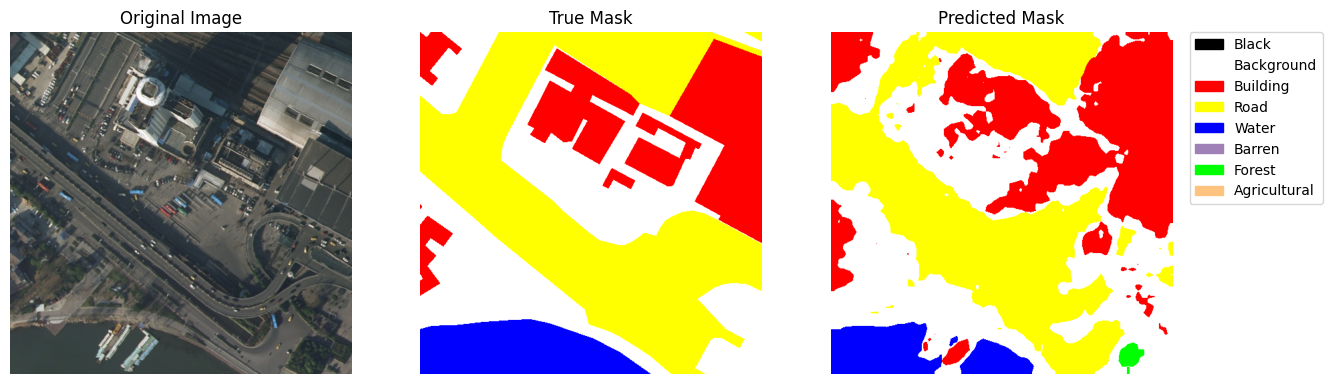

Epoch 19/20: 100%|██████████| 37/37 [01:21<00:00,  2.20s/it]


Epoch 19, Learning Rate: 0.000100, Average Loss: 0.2643


IoU per category (%):
 Background: 46.02%
 Building: 35.10%
 Road: 29.94%
 Water: 28.27%
 Barren: 5.72%
 Forest: 8.54%
 Agricultural: 33.06%

mIoU: 26.67%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2]
Unique values in predicted mask: [0 1 2 5]



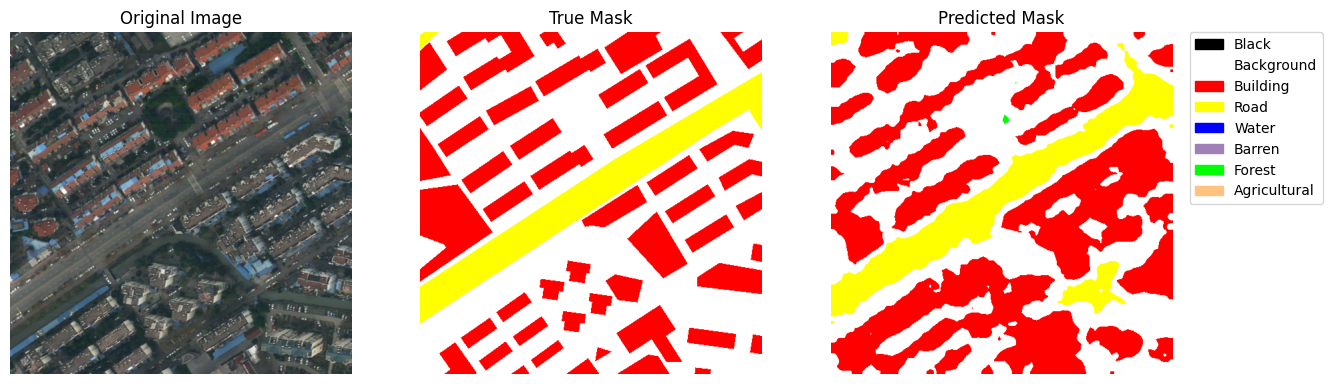

Epoch 20/20: 100%|██████████| 37/37 [01:23<00:00,  2.25s/it]


Epoch 20, Learning Rate: 0.000100, Average Loss: 0.2723


IoU per category (%):
 Background: 44.43%
 Building: 33.42%
 Road: 28.57%
 Water: 26.64%
 Barren: 5.31%
 Forest: 8.12%
 Agricultural: 32.10%

mIoU: 25.51%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [-1  0  2  3  5]
Unique values in predicted mask: [0 1 2 3 5]



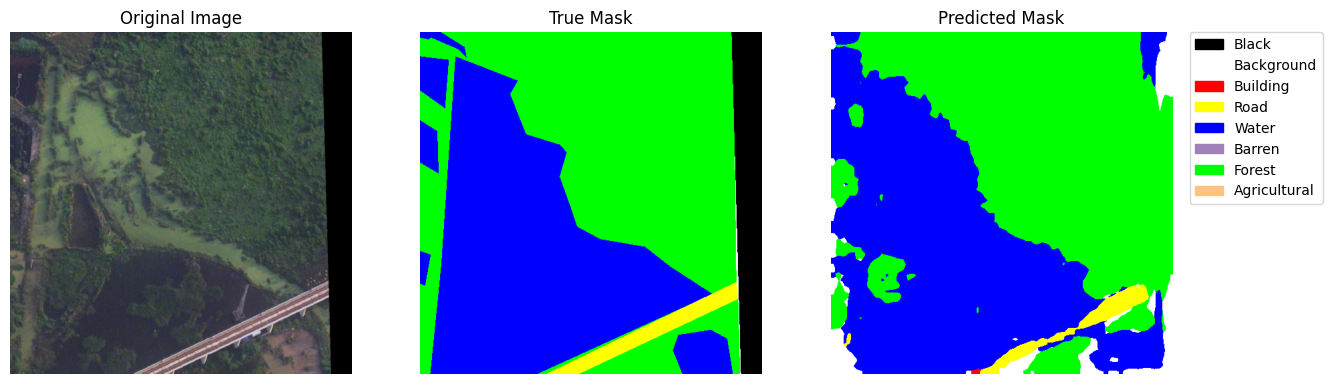

In [ ]:
#Scheduler
def poly_lr_scheduler(optimizer, init_lr, iter, max_iter, power=0.9):
    lr = init_lr * (1 - iter / max_iter) ** power
    optimizer.param_groups[0]['lr'] = lr
    return lr

# Optimizer configuration, loss function, and GradScaler
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=STEP_SIZE, gamma=GAMMA)
#criterion = nn.CrossEntropyLoss(weight= class_weights, ignore_index = -1)
criterion = FocalLoss(alpha = 1, gamma = 2, ignore_index = -1)

# Training loop
scaler = torch.amp.GradScaler()
num_epochs = NUM_EPOCHS
global_iter = 0  # Global iteration counter

loss_history = []
lr_history = []
miou_history = []

augmentations = DataAugmentation(probability=0.5)

best_miou = 0.0  # Initialize best mIoU

if trained == False:
  for epoch in range(num_epochs):
      model.train()
      total_loss = 0.0

      for images, masks in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
          images, masks = images.to(device), masks.to(device)

          # Applica data augmentation
          augmented_images = []
          augmented_masks = []
          for img, mask in zip(images, masks):
              aug_img, aug_mask = augmentations(img, mask)  # Applica le trasformazioni
              augmented_images.append(aug_img)
              augmented_masks.append(aug_mask)

          # Converti le liste di immagini e maschere in batch di tensori
          augmented_images = torch.stack(augmented_images).to(device)
          augmented_masks = torch.stack(augmented_masks).to(device)

          optimizer.zero_grad()
          with torch.cuda.amp.autocast():
              outputs = model(augmented_images)
              #Scale the output to the desired size x = torch.nn.functional.interpolate(x, size=(H, W), mode='bilinear')
              outputs_resized = torch.nn.functional.interpolate(outputs, size=(512, 512), mode='bilinear')
              loss = criterion(outputs_resized, augmented_masks) # Compute loss

          scaler.scale(loss).backward() # Backpropagation
          scaler.step(optimizer)             # Update weights
          scaler.update()                     # Update GradScaler
          total_loss += loss.item()

      avg_loss = total_loss / len(train_loader)
      loss_history.append(avg_loss)  # Append to the list
      scheduler.step()
      lr = optimizer.param_groups[0]['lr']
      lr_history.append(lr)
      print()
      print(f"Epoch {epoch + 1}, Learning Rate: {lr:.6f}, Average Loss: {avg_loss:.4f}")

      # Validation every epoch
      mIoU = compute_mIoU(model, val_loader, num_classes=NUM_CLASSES, device=device)
      miou_history.append(mIoU)
      # Save the best model based on mIoU
      if mIoU > best_miou:
            best_miou = mIoU
            torch.save(model.state_dict(), "/content/best_model_pidnet_DS_512_32_wHF_FocalLoss_MultiStepLR.pth")
            print(f"New best model saved with mIoU: {best_miou:.4f}")

      model.eval()
      '''Take a sample image and compare prediction'''
        # Load a batch of data
      sample_image, sample_label = next(iter(train_loader))  # A batch from DataLoader
      sample_image = sample_image[0]  # Select a single example
      sample_label = sample_label[0]

      # Get prediction from model
      with torch.no_grad():
          sample_image = sample_image.to(device)  # Transfer image to correct device
          pred_mask = model(sample_image.unsqueeze(0)) # Add batch dimension
          pred_mask_resized = torch.nn.functional.interpolate(
              pred_mask,
              size=(512, 512),
              mode='bilinear'
          )
          pred_mask = pred_mask_resized.argmax(dim=1).squeeze(0)  # Predicted class

      # Visualize prediction
      visualize_prediction(sample_image, sample_label, pred_mask)

      trained = True
      plot_training = True
else:
  print("Model already trained")
  model.load_state_dict(torch.load("/content/best_model_pidnet_DS_512_32_wHF_FocalLoss_MultiStepLR.pth", weights_only=True))
  model.to(device)

# **Results**

In [22]:
model.load_state_dict(torch.load("/content/best_model_pidnet_DS_512_32_wHF_FocalLoss_MultiStepLR.pth", weights_only=True))
model.to(device)
# Compute mIoU
mIoU = compute_mIoU(model, val_loader, num_classes=NUM_CLASSES, device=device)

IoU per category (%):
 Background: 45.53%
 Building: 36.70%
 Road: 30.47%
 Water: 28.10%
 Barren: 5.27%
 Forest: 8.80%
 Agricultural: 34.16%

mIoU: 27.00%



## Final graph

In [ ]:
import matplotlib.pyplot as plt

def plot_training_metrics(loss_history, lr_history, miou_history):
    """
    Function to plot loss, learning rate, and mIoU graph.

    Parameters:
    - loss_history: list containing loss values for each epoch.
    - lr_history: list containing learning rate values for each epoch.
    - miou_history: list containing mIoU values calculated every 5 epochs.
    """
    plt.figure(figsize=(18, 6))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(loss_history, label='Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.xticks(range(len(loss_history)))  # Set xticks as integer numbers

    # Learning Rate plot
    plt.subplot(1, 3, 2)
    plt.plot(lr_history, label='Learning Rate', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate')
    plt.legend()
    plt.xticks(range(len(lr_history)))  # Set xticks as integer numbers

    # mIoU plot
    plt.subplot(1, 3, 3)
    plt.plot(miou_history, label='mIoU', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.title('Mean IoU')
    plt.legend()
    plt.xticks(range(len(miou_history)))  # Integer ticks every 5 epochs

    plt.tight_layout()
    plt.show()

if plot_training:
  # Plot the training metrics graph
  plot_training_metrics(loss_history, lr_history, miou_history)